Epoch 1/10 — Loss: 0.5347, Val F1: 0.7924
Epoch 2/10 — Loss: 0.4537, Val F1: 0.8506
Epoch 3/10 — Loss: 0.4059, Val F1: 0.8587
Epoch 4/10 — Loss: 0.3981, Val F1: 0.8644
Epoch 5/10 — Loss: 0.3591, Val F1: 0.8795
Epoch 6/10 — Loss: 0.3346, Val F1: 0.9098
Epoch 7/10 — Loss: 0.3219, Val F1: 0.8344
Epoch 8/10 — Loss: 0.3212, Val F1: 0.9175
Epoch 9/10 — Loss: 0.2926, Val F1: 0.9159
Epoch 10/10 — Loss: 0.2816, Val F1: 0.8986

=== TRAINING SET METRICS ===
Accuracy : 0.8788
Precision: 0.8943
Recall   : 0.8759
F1 (wtd) : 0.8789
ROC AUC  : 0.9533


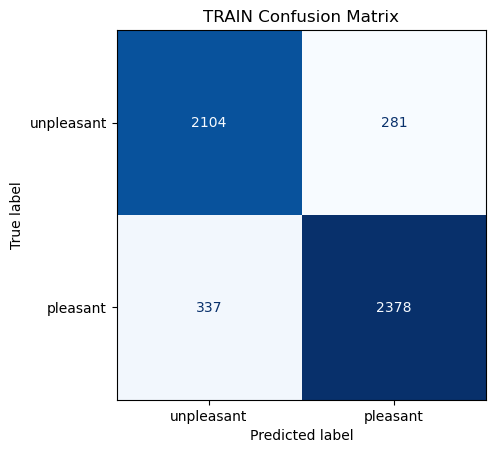

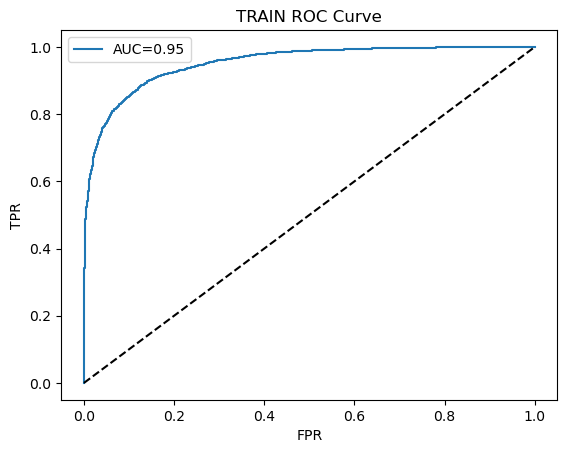

Optimal threshold: 0.46, Val F1: 0.9188


In [ ]:
import multiprocessing as mp
mp.set_start_method('fork', force=True)  # Ensure 'fork' method for DataLoader workers on Unix systems

from pathlib import Path
import os
import random
import time
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# ------------------ Step 1: Constants & Configuration ------------------
SEED        = 42
TRAIN_DIR   = Path(r"/Users/nicoletatour/Desktop/train-images/train")   # Training images directory
TEST_IMG_DIR= Path(r"/Users/nicoletatour/Desktop/TEST_images/TEST_images")  # Test images directory
IDS_CSV     = Path(r"/Users/nicoletatour/Desktop/Test-IDs.csv")         # CSV mapping filenames to IDs
LABEL_MAP   = {'unpleasant': 0, 'pleasant': 1}  # Class label mapping
IMG_SIZE    = 64      # Resize images to 64×64
BATCH_SIZE  = 64      # Number of samples per batch
EPOCHS      = 10      # Number of training epochs
LR          = 1e-4    # Initial learning rate

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if available

# ------------------ Step 2: Dataset Definition ------------------
class FaceDataset(Dataset):
    def __init__(self, samples, labels_available=True, transform=None):
        """
        samples: list of (path, label) tuples or list of paths if unlabeled
        labels_available: whether labels are provided
        transform: torchvision transforms to apply
        """
        self.samples = samples
        self.labels_available = labels_available
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Get path and label (or -1 if unlabeled)
        if self.labels_available:
            path, label = self.samples[idx]
        else:
            path = self.samples[idx]
            label = -1
        # Load image and convert to RGB
        img = Image.open(str(path)).convert("RGB")
        # Apply transforms (augmentation or simple resize + normalize)
        if self.transform:
            img = self.transform(img)
        return img, label, str(path)

# ------------------ Step 3: Model Definition ------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional backbone: 5 blocks of Conv3×3 → BatchNorm → ReLU → MaxPool2d(2×2)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  nn.BatchNorm2d(32),  nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64),  nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256, 3, padding=1),nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(256,512, 3, padding=1),nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2),
        )
        # Flatten and classification head
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(512 * (IMG_SIZE // 32) * (IMG_SIZE // 32), 256),  # Flattened features → 256
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 64),                                         # 256 → 64
            nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 2)                                            # 64 → 2 output logits
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.fc(x)

# ------------------ Step 4: Utility Functions ------------------
def optimize_threshold(y_true, probs):
    """
    Search thresholds from 0.10 to 0.89 in 0.01 steps
    to find the one maximizing F1-score.
    """
    best_f1, best_thr = 0.0, 0.5
    for thr in np.arange(0.1, 0.9, 0.01):
        preds = (probs >= thr).astype(int)
        f = f1_score(y_true, preds)
        if f > best_f1:
            best_f1, best_thr = f, thr
    return best_thr, best_f1

def evaluate(model, loader, device):
    """
    Compute confusion matrix, accuracy, precision,
    recall, weighted F1, and ROC-AUC on a DataLoader.
    """
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for X, y, _ in loader:
            X = X.to(device)
            logits = model(X)
            probs  = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # probability of class 1
            preds  = np.argmax(logits.cpu().numpy(), axis=1)
            y_true.extend(y.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)
    return {
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred, average='weighted'),
        'roc_auc': auc(*roc_curve(y_true, y_prob)[:2])
    }

# ------------------ Step 5: Main Training & Evaluation Pipeline ------------------
def main():
    # 5.1: Set random seeds for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    # 5.2: Gather train samples and test image paths
    train_samples = []
    for cls, lbl in LABEL_MAP.items():
        for img_path in (TRAIN_DIR / cls).iterdir():
            if img_path.suffix.lower() in {'.png','.jpg','.jpeg'}:
                train_samples.append((img_path, lbl))
    test_paths = sorted([p for p in TEST_IMG_DIR.iterdir()
                         if p.suffix.lower() in {'.png','.jpg','.jpeg'}])

    # 5.3: Load filename→ID mapping from CSV
    df_ids = pd.read_csv(IDS_CSV)
    if 'Filename' in df_ids.columns and 'ID' in df_ids.columns:
        fname2id = dict(zip(df_ids['Filename'], df_ids['ID']))
        ids = [fname2id[p.name] for p in test_paths]
    else:
        ids = df_ids['ID'].tolist()

    # 5.4: Define data augmentations and preprocessing
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0), ratio=(0.75,1.33)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.2,0.2,0.2,0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        transforms.RandomErasing(p=0.5)
    ])
    test_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

    # 5.5: Split into training/validation and create DataLoaders
    paths, labels = zip(*train_samples)
    paths, labels = np.array(paths), np.array(labels)
    tr_p, val_p, y_tr, y_val = train_test_split(
        paths, labels, test_size=0.2, stratify=labels, random_state=SEED
    )
    train_ds = FaceDataset(list(zip(tr_p,y_tr)), True, train_tf)
    val_ds   = FaceDataset(list(zip(val_p,y_val)), True, test_tf)
    test_ds  = FaceDataset(test_paths, False, test_tf)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
    val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # 5.6: Initialize model, loss function, optimizer, and scheduler
    model     = SimpleCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0,1.5]).to(DEVICE))
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.3
    )

    # 5.7: Training loop with validation and model checkpointing
    best_f1 = 0.0
    for ep in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        for X, y, _ in train_dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)

        # Validation step
        model.eval()
        vp, vl = [], []
        with torch.no_grad():
            for X, y, _ in val_dl:
                preds = torch.argmax(model(X.to(DEVICE)), dim=1).cpu().numpy()
                vp.extend(preds); vl.extend(y.numpy())
        val_f1 = f1_score(vl, vp)
        scheduler.step(val_f1)  # Adjust learning rate if no improvement
        print(f"Epoch {ep}/{EPOCHS} — Loss: {running_loss/len(train_ds):.4f}, Val F1: {val_f1:.4f}")

        # Save the model if validation F1 improves
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

    # 5.8: Load best model & display training metrics
    model.load_state_dict(torch.load('best_model.pth'))
    tm = evaluate(model, train_dl, DEVICE)
    print("\n=== TRAINING SET METRICS ===")
    print(f"Accuracy : {tm['accuracy']:.4f}")
    print(f"Precision: {tm['precision']:.4f}")
    print(f"Recall   : {tm['recall']:.4f}")
    print(f"F1 (wtd) : {tm['f1']:.4f}")
    print(f"ROC AUC  : {tm['roc_auc']:.4f}")
    disp = ConfusionMatrixDisplay(tm['confusion_matrix'], display_labels=list(LABEL_MAP.keys()))
    disp.plot(cmap='Blues', colorbar=False)
    plt.title('TRAIN Confusion Matrix'); plt.show()

    # Plot ROC curve for training set
    y_t, y_p = [], []
    with torch.no_grad():
        for X, y, _ in train_dl:
            logits = model(X.to(DEVICE))
            y_p.extend(torch.softmax(logits,1)[:,1].cpu().numpy())
            y_t.extend(y.numpy())
    fpr, tpr, _ = roc_curve(y_t, y_p)
    plt.plot(fpr, tpr, label=f"AUC={tm['roc_auc']:.2f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('TRAIN ROC Curve'); plt.legend(); plt.show()

    # 5.9: Find the optimal threshold on the validation set
    vp, vt = [], []
    with torch.no_grad():
        for X, y, _ in val_dl:
            logits = model(X.to(DEVICE))
            vp.extend(torch.softmax(logits,1)[:,1].cpu().numpy())
            vt.extend(y.numpy())
    best_thr, best_thr_f1 = optimize_threshold(np.array(vt), np.array(vp))
    print(f"Optimal threshold: {best_thr:.2f}, Val F1: {best_thr_f1:.4f}")

    # 5.10: Predict on the test set and save submission
    test_probs = []
    with torch.no_grad():
        for X, _, _ in test_dl:
            test_probs.extend(torch.softmax(model(X.to(DEVICE)),1)[:,1].cpu().numpy())
    labels = (np.array(test_probs) >= best_thr).astype(int)
    submission = pd.DataFrame({'ID': ids, 'LABEL': labels})
    submission.to_csv('submission_cnn.csv', index=False)
    print(f"Saved submission_cnn64.csv (threshold={best_thr:.2f})")

if __name__ == '__main__':
    main()
